In [1]:
# Importing Libraries 
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
# Data Loading 
Data_Dir = r"C:\Users\lovey\OneDrive\Desktop\DataSets\monte-carlo-lms-energy-modeling\Data"

# Creating Dataframes
train_df = pd.read_csv(f"{Data_Dir}\\train.csv")
building_df = pd.read_csv(f"{Data_Dir}\\building_metadata.csv")
weather_df = pd.read_csv(f"{Data_Dir}\\weather_train.csv")

# Sanity Checks 
print("Train Shape: ", train_df.shape)
print("Building Shape: ", building_df.shape)
print("Weather Shape: ", weather_df.shape)

Train Shape:  (20216100, 4)
Building Shape:  (1449, 6)
Weather Shape:  (139773, 9)


In [3]:
# Timestamp parsing
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"])

In [4]:
# Inspect and select suitable site_id (Data Driven site choice)

In [5]:
# Inspect available sites in the training data 
# Number of records per site( electricity only assumed later)
site_counts = (
    train_df.merge(building_df[["building_id","site_id"]], on = "building_id", how = "left")
    ["site_id"]
    .value_counts()
    .sort_index()
)

# Check weather coverage per site
weather_site_counts = weather_df["site_id"].value_counts().sort_index()

# Combining both views 
site_summary = pd.DataFrame({
    "train_records":site_counts,
    "weather_records": weather_site_counts
}).dropna()

print(site_summary)

         train_records  weather_records
site_id                                
0              1076662             8784
1               553357             8763
2              2530312             8783
3              2370097             8780
4               746746             8783
5               781776             8755
6               668133             8782
7               366681             8614
8               567915             8784
9              2679323             8780
10              411407             8782
11              119459             8614
12              315909             8755
13             2711763             8783
14             2501506             8777
15             1815054             8454


In [6]:
# Defining explicit seletion rules
MIN_TRAIN_RECORDS = site_summary["train_records"].quantile(0.5)
MIN_WEATHER_RECORDS = site_summary["weather_records"].quantile(0.5)

site_summary_filtered = site_summary[
    (site_summary["train_records"]>=MIN_TRAIN_RECORDS) &
    (site_summary["weather_records"]>=MIN_WEATHER_RECORDS)
]

# Scoring Remaining sites(balanced coverage)
site_summary_filtered = site_summary_filtered.copy()
site_summary_filtered.loc[:,"coverage_ratio"] = (
    site_summary_filtered["train_records"]/site_summary_filtered["weather_records"])

# Penalize extreme imbalance
site_summary_filtered.loc[:,"balanced_score"] = np.abs(np.log(site_summary_filtered["coverage_ratio"]))

site_summary_filtered.sort_values("balanced_score")
# Lower balance score = better balance

print(site_summary_filtered)

         train_records  weather_records  coverage_ratio  balanced_score
site_id                                                                
0              1076662             8784      122.570811        4.808689
2              2530312             8783      288.091996        5.663280
3              2370097             8780      269.942711        5.598210
9              2679323             8780      305.162073        5.720843
13             2711763             8783      308.751338        5.732536


In [7]:
# Selecting suitable site_id 
SELECTED_SITE_ID = site_summary_filtered.sort_values(
    by = ["balanced_score","train_records"],
    ascending = [True,False]
).index[0]
 
print(SELECTED_SITE_ID)

# Lock the selection
SITE_ID = int(SELECTED_SITE_ID)
print(f"Selected site_id: {SITE_ID}")

0
Selected site_id: 0


In [8]:
# Locking the dataset and finish the preprocessing pipeline

#restrict to electricity meter only
train_site_df = train_df[train_df["meter"]==0].copy()

print("Electricity records:", train_site_df.shape)

# Join static building metadat(context)
building_features = [
    "building_id",
    "site_id",
    "square_feet",
    "year_built",
    "primary_use"
]

train_site_df = train_site_df.merge(
    building_df[building_features],
    on = "building_id",
    how = "left"
)

# Join weather data(Uncertain exogenous inputs)
weather_features = [
    "site_id",
    "timestamp",
    "air_temperature",
    "dew_temperature",
    "wind_speed"
]
weather_site_df = weather_df[weather_features].copy()

data_df = train_site_df.merge(
    weather_site_df,
    on = ["site_id","timestamp"],
    how = "left"
)

print("after weather join", data_df.shape)

# handeling missing values
required_cols = [ 
    "meter_reading",
    "air_temperature",
    "dew_temperature",
    "wind_speed",
    "square_feet"
]

data_df = data_df.dropna(subset=required_cols).copy()
print("After dropping missing values:", data_df.shape)

Electricity records: (12060910, 4)
after weather join (12060910, 11)
After dropping missing values: (11991366, 11)


In [9]:
# Feature Transformations(for stability)
# log-transform heavy-tailed quantities 
data_df["log_meter_reading"] = np.log1p(data_df["meter_reading"])
data_df["log_square_feet"] = np.log1p(data_df["square_feet"])

# Time based features(deterministic)
data_df["hour"] = data_df["timestamp"].dt.hour
data_df["dayofweek"] = data_df["timestamp"].dt.dayofweek

# Final feature set(locked)
FEATURES = [
    "air_temperature",
    "dew_temperature",
    "wind_speed",
    "hour",
    "dayofweek",
    "log_square_feet"
]

TARGET = "log_meter_reading"

X = data_df[FEATURES].values
y = data_df[TARGET].values

print("X shape:", X.shape)
print("y shape:", y.shape)

# Time-Aware Train / Validation Split (Non-Negotiable)
data_df = data_df.sort_values("timestamp")

split_ratio = 0.8
split_idx = int(len(data_df) * split_ratio)

X_train = X[:split_idx]
y_train = y[:split_idx]

X_val = X[split_idx:]
y_val = y[split_idx:]

print("Train samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])

# Feature normalization 
X_mean = X_train.mean(axis = 0)
X_std = X_train.std(axis = 0) + 1e-8 #numerical safety 

X_train_norm = (X_train - X_mean)/X_std
X_val_norm = (X_val - X_mean)/X_std

X shape: (11991366, 6)
y shape: (11991366,)
Train samples: 9593092
Validation samples: 2398274


In [10]:
# Uncertainty modelling and Monte carlo design 

In [11]:
# Prepare feature indices 
# we need to know which features get noise 
feature_names = FEATURES

weather_feature_names = [
    "air_temperature",
    "dew_temperature",
    "wind_speed"
]
weather_feature_indices = [
    feature_names.index(f) for f in weather_feature_names
]

print(weather_feature_indices)

[0, 1, 2]


In [12]:
# Estimating noise scales from training data 

# standard deviation per feature(training data)
feature_stds = X_train_norm.std(axis = 0)

# Noise strength (5% of feature std is a good starting point)
NOISE_LEVEL = 0.05

noise_scales = {
    idx: NOISE_LEVEL * feature_stds[idx]
    for idx in weather_feature_indices
}
print(noise_scales)

{0: 0.04999999995144511, 1: 0.0499999999492077, 2: 0.04999999978291061}


In [13]:
def monte_carlo_perturb(x, noise_scales, n_mc=100):
    """
    Generate Monte Carlo perturbed versions of input data.

    Parameters
    ----------
    x : np.ndarray
        Normalized input features (n_points, n_features)
    noise_scales : dict
        Mapping feature_index -> noise std
    n_mc : int
        Number of Monte Carlo samples

    Returns
    -------
    X_mc : np.ndarray
        Shape (n_mc, n_points, n_features)
    """
    n_points, n_features = x.shape

    # Allocate MC array safely
    X_mc = np.repeat(x[None, :, :], n_mc, axis=0)

    for idx, scale in noise_scales.items():
        noise = np.random.normal(
            loc=0.0,
            scale=scale,
            size=(n_mc, n_points)
        )
        X_mc[:, :, idx] += noise

    return X_mc

X_mc = monte_carlo_perturb(
    X_val_norm[:10],
    noise_scales,
    n_mc=200
)

print("MC shape:", X_mc.shape)

MC shape: (200, 10, 6)


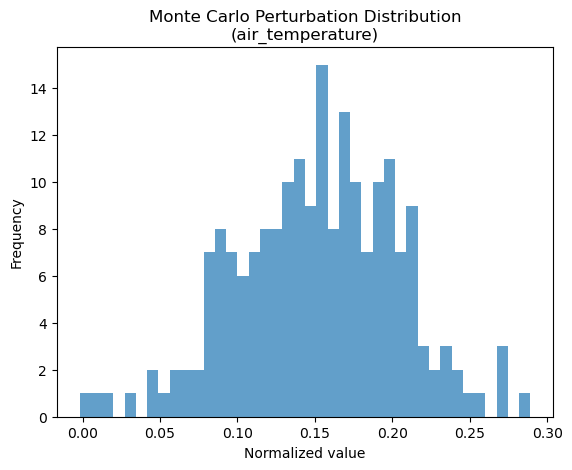

In [14]:
# Visualize uncertainty( one feature, one sample)
feature_idx = weather_feature_indices[0]  # air_temperature

plt.hist(
    X_mc[:, 0, feature_idx],
    bins=40,
    alpha=0.7
)
plt.title("Monte Carlo Perturbation Distribution\n(air_temperature)")
plt.xlabel("Normalized value")
plt.ylabel("Frequency")
plt.show()

In [15]:
# LMS (SGD) Implementation for Linear Regression

In [16]:
# LMS model class 
class LMSRegressor:
    def __init__(self, n_features, learning_rate = 0.01):
        self.lr = learning_rate
        self.w = np.zeros(n_features)
        self.b = 0.0

        # tracking for diagnostics
        self.loss_history = []

    def predict(self,X):
        return X @ self.w + self.b

    def update(self,x,y):
        """
        Perform one LMS update using a single sample
        """
        y_hat = np.dot(self.w,x) + self.b
        error = y - y_hat

        #LMS Update
        self.w += self.lr*error*x
        self.b += self.lr*error

        return error

    def fit(self, X,y,n_epochs, shuffle = True):
        n_samples = X.shape[0]

        for epoch in range(n_epochs):
            if shuffle:
                indices = np.random.permutation(n_samples)
            else:
                indices = np.arrange(n_samples)

            epoch_loss = 0.0

            for i in indices:
                error = self.update(X[i],y[i])
                epoch_loss += 0.5*error**2
            self.loss_history.append(epoch_loss/n_samples)

In [17]:
# Train the LMS model(deterministic)
# first training the model without monte carlo 
n_features = X_train_norm.shape[1]

lms = LMSRegressor(
    n_features = n_features,
    learning_rate = 0.01
)

lms.fit(
    X_train_norm,
    y_train,
    n_epochs = 10,
    shuffle = True
)

In [18]:
print(len(lms.loss_history))
print(lms.loss_history)

10
[0.9685502376246189, 0.9684642180146981, 0.9683667515026126, 0.9684962554806403, 0.9685049008884145, 0.9684583776907295, 0.9685104789317643, 0.9684902185784102, 0.9685092995497131, 0.9685245431003665]


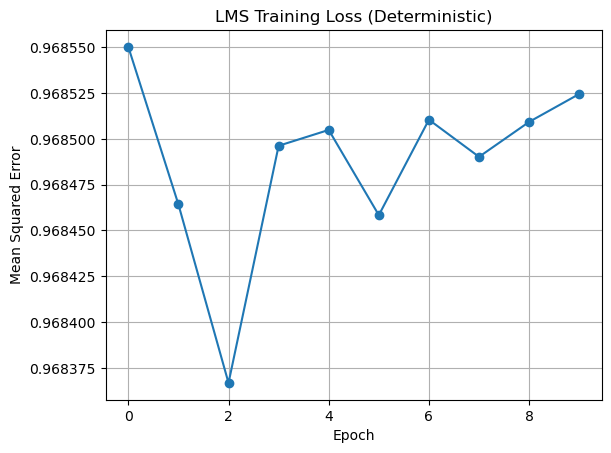

In [19]:
# Convergence diagnostics 
plt.plot(lms.loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("LMS Training Loss (Deterministic)")
plt.grid(True)
plt.show()

In [20]:
# Monte Cralo Prediction and uncertainty analysis

# we propogate input uncertainty(weather noise) through a fixed trained LMS model to obtain the distributions of predictions, not just point estimates.

In [21]:
# Selecting a small validation batch for uncertainty analysis
N_points = 50

X_batch = X_val_norm[:N_points]
y_batch = y_val[:N_points]

In [22]:
# Generate monte carlo pertubations 

N_MC = 500 # no. of monte carlo samples 

X_mc = monte_carlo_perturb(
    X_batch,
    noise_scales,
    n_mc = N_MC
)

print("MC input shape: ",X_mc.shape)

MC input shape:  (500, 50, 6)


In [23]:
# Montecarlo prdeictions with frozen LMS
y_mc_pred = np.zeros((N_MC,N_points))

for k in range(N_MC):
    y_mc_pred[k] = lms.predict(X_mc[k])

In [24]:
# Determinsitic vs Monte Carlo Predictions

#Deterministic(No noise) prediction
y_det_pred = lms.predict(X_batch)

In [25]:
# Computing the uncertainty statistics
y_mc_mean = y_mc_pred.mean(axis=0)
y_mc_std = y_mc_pred.std(axis=0)

# 95% Confidence interval 
y_mc_lower = np.percentile(y_mc_pred, 2.5, axis=0)
y_mc_upper = np.percentile(y_mc_pred, 97.5, axis=0)

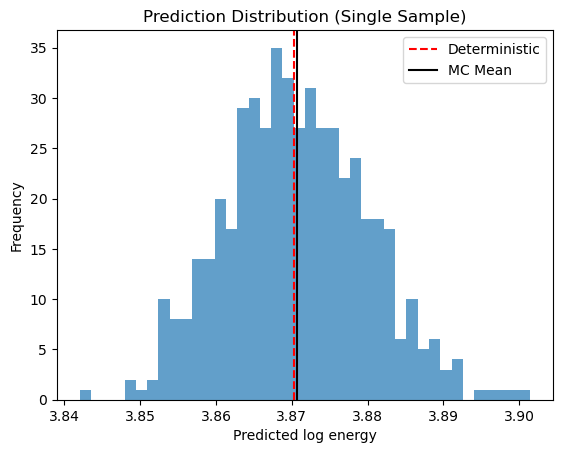

In [26]:
# Visualizing Uncertainty prediction(Key Plot)
idx = 0  # first validation sample

plt.hist(y_mc_pred[:, idx], bins=40, alpha=0.7)
plt.axvline(y_det_pred[idx], color="red", linestyle="--", label="Deterministic")
plt.axvline(y_mc_mean[idx], color="black", linestyle="-", label="MC Mean")
plt.title("Prediction Distribution (Single Sample)")
plt.xlabel("Predicted log energy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

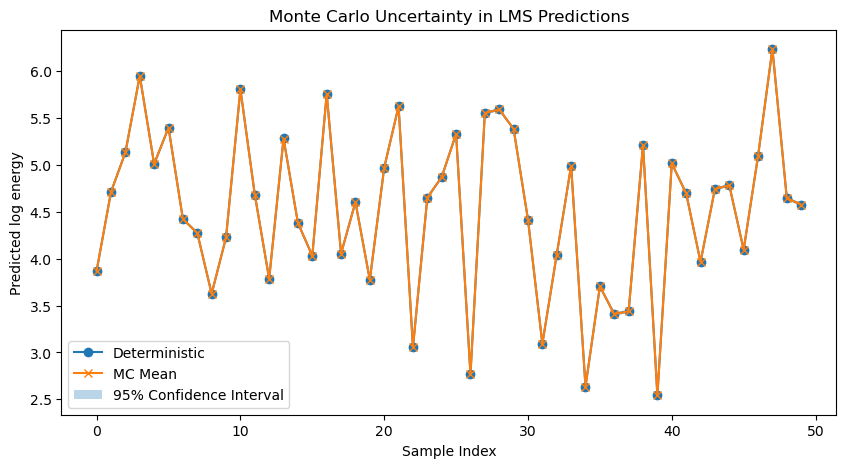

In [28]:
# Prediction bands across multiple points
plt.figure(figsize=(10, 5))

plt.plot(y_det_pred, label="Deterministic", marker="o")
plt.plot(y_mc_mean, label="MC Mean", marker="x")

plt.fill_between(
    range(N_points),
    y_mc_lower,
    y_mc_upper,
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.xlabel("Sample Index")
plt.ylabel("Predicted log energy")
plt.title("Monte Carlo Uncertainty in LMS Predictions")
plt.legend()
plt.show()

In [29]:
# Quantifying prediction risk
cv = y_mc_std/(np.abs(y_mc_mean)+ 1e-6)

print("Mean CV:", np.mean(cv))
print("Max CV:", np.max(cv))

# Interpretation:  )Higher CV → less reliable prediction
#                  )Useful for risk-aware decisions

Mean CV: 0.0021076210183737336
Max CV: 0.003666539158679877


In [30]:
# Sensitivity to Noise level 
for noise_level in [0.01, 0.05, 0.1]:
    noise_scales_test = {
        idx: noise_level * feature_stds[idx]
        for idx in weather_feature_indices
    }

    X_mc_test = monte_carlo_perturb(
        X_batch,
        noise_scales_test,
        n_mc=200
    )

    y_mc_test = np.array([
        lms.predict(X_mc_test[k]) for k in range(200)
    ])

    print(f"Noise level {noise_level:.2f} → mean std:",
          y_mc_test.std(axis=0).mean())

Noise level 0.01 → mean std: 0.001790300984662273
Noise level 0.05 → mean std: 0.009095799845021369
Noise level 0.10 → mean std: 0.018162060633094657
